In [1]:
# notebook last tested with abtem version 1.0.0beta7

from abtem import __version__
print('current version:', __version__)

from ase.cluster import Decahedron
from abtem.visualize import show_atoms

import matplotlib.pyplot as plt
import numpy as np
from abtem import *

current version: 1.0.0beta7


# STEM simulation with PRISM

STEM image with a million probe positions. 1 minute per frozen phonon configuration on a single NVidia 2080 Ti GPU using the PRISM algorithm.

In [2]:
device = 'gpu'

# We need to disable the fft planning cache.
# For large fourier transforms the memory required by the cache is better utilized on increasing the batch size.

from cupy.fft.config import get_plan_cache, show_plan_cache_info
cache = get_plan_cache()
cache.set_size(0)

In [3]:
p = 20
q = 3
r = 1

atoms = Decahedron('Au', p, q, r, latticeconstant=None)
atoms.rotate(30, 'x', center='cop')

atoms.center(vacuum=5)

In [4]:
help(Decahedron)

Help on function Decahedron in module ase.cluster.decahedron:

Decahedron(symbol, p, q, r, latticeconstant=None)
    Return a decahedral cluster.
    
    Parameters
    ----------
    symbol: Chemical symbol (or atomic number) of the element.
    
    p: Number of atoms on the (100) facets perpendicular to the five
    fold axis.
    
    q: Number of atoms on the (100) facets parallel to the five fold
    axis. q = 1 corresponds to no visible (100) facets.
    
    r: Depth of the Marks re-entrence at the pentagon corners. r = 0
    corresponds to no re-entrence.
    
    latticeconstant (optional): The lattice constant. If not given,
    then it is extracted form ase.data.



In [5]:
potential = Potential(FrozenPhonons(atoms, 1, {'Au':.0}), 
                      gpts=2048, device=device, storage='gpu', 
                      projection='infinite', parametrization='kirkland')#.build(pbar=True)

In [6]:
potential.sampling

(0.052727025710360434, 0.0457235572938147)

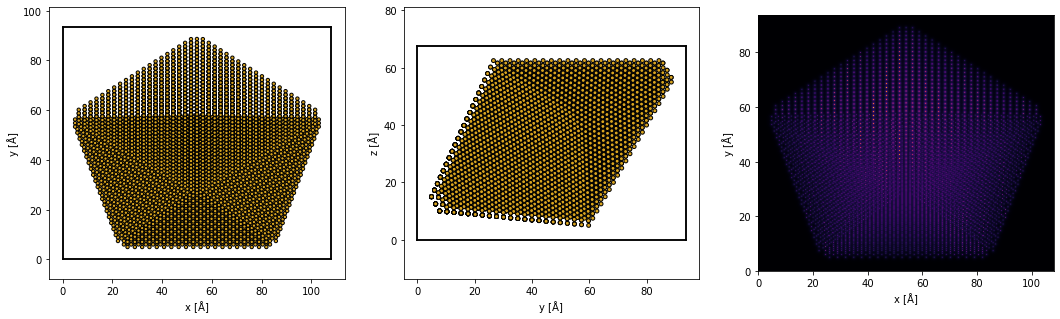

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
show_atoms(atoms, ax=ax1)
show_atoms(atoms, ax=ax2, plane='yz')
potential.project().show(ax=ax3, cmap='inferno', power=.5);

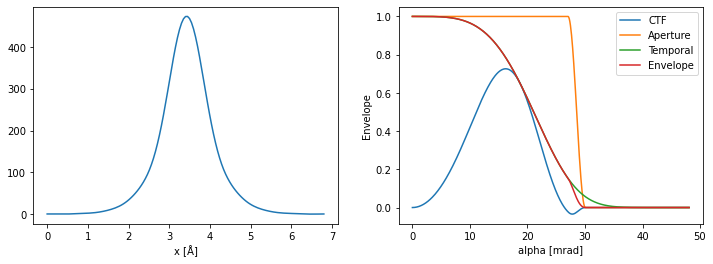

In [8]:
S = SMatrix(energy=80e3, expansion_cutoff=30, semiangle_cutoff=30, interpolation=16, device='gpu', storage='gpu')

S.ctf.defocus = 60
S.ctf.focal_spread = 50

S.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

S.profile().show(ax=ax1);
S.ctf.show(ax=ax2);

In [10]:
scan = GridScan((0,0), potential.extent, sampling=.1)
detector = FlexibleAnnularDetector()

measurements = S.scan(scan, [detector], potential, max_batch_expansion=35)

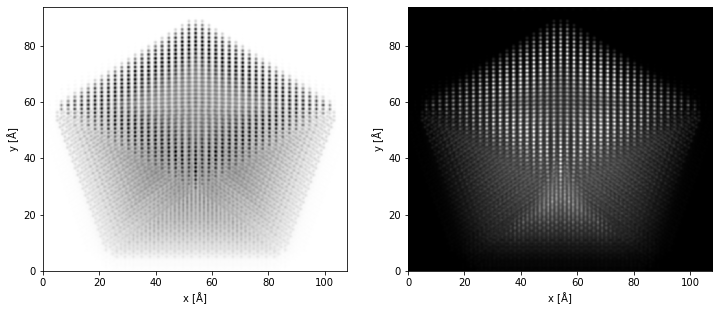

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

measurements[detector].integrate(0, 30).show(ax=ax1)
measurements[detector].integrate(70, 150).show(ax=ax2);